# Tamil-English Sentiment Analysis

In his notebook I create a fine-tuned model for sentiment analysis of text written in mixed a mixture of Tamil and English language.

I use a __weighted__ version of the loss function to account for the great imbalance in the classes of the dataset.
I also tune the tokenizer to recognize __emojis__ as those are generally relevant to express sentiment.
My model is based on a pre-trained multilingual model which includes Tamil and English; 
this should help in the text classification process.

The dataset was firs published in the (UCI Machine Learning Repository)[http://archive.ics.uci.edu/ml/datasets/TamilSentiMix]
and later published in the (Hugging Face Data Repository)[https://huggingface.co/datasets/tamilmixsentiment]
from where I read it in this notebook.
The original paper explaining the data set can be found at:
<https://aclanthology.org/2020.sltu-1.28.pdf>

The new model __outperforms__ the original one presented in the paper and based on the original BERT language model.
Hence the use of weights, emojis and a multilingual language schema seems to be an appropriated improved methodology.

The notebook was ran using an Amazon SageMaker Notebook `ml.g5.xlarge`


In [1]:
%pip install matplotlib transformers datasets emojis

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
import emojis
import torch
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import datasets

transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# Use GPU if available
device = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# PARAMETERS

# This is the dataset to be downloaded from https://huggingface.co/datasets/tamilmixsentiment
dataset_name = 'tamilmixsentiment'

# This sets the batch size to be used in the fine tuning
# batch_size, language_model_name = 8, 'distilbert-base-uncased'        # good for sagemaker studio lab
# batch_size, language_model_name = 32, 'bert-base-multilingual-cased'  # good for sagemaker notebook ml.p3.2xlarge
batch_size, language_model_name = 64, 'bert-base-multilingual-cased'  # good for sagemaker notebook ml.g5.xlarge

# DATA
dataset = datasets.load_dataset(dataset_name, )

# Use a random subset of the data for development
# dataset = datasets.DatasetDict(
#     {k: v.shuffle(2023).select(range(int(v.num_rows * 0.1))) for k, v in dataset.items()}
# )

dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 126
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 314
    })
})

In [4]:
# Show the training split of the data
dataset['train'].to_pandas()

,text,label
0,Bgm Vera level.. Yuvan rocks,0
1,Chiyaan Anna vera level,0
2,Semma fulla Rajinism than ..... Semma super,0
3,Oruthar mela nenga visawasam katrarukaha innor...,0
4,petta parak... Kola Kandula iruken. Thalaiva r...,0
...,...,...
1128,I am Surya fan But all time favorite superstar,0
1129,U1 bgm Hero trailer-Comment Ar Rahman bgm bigi...,0
1130,Chennai la booking start aagiduchu movie ku,0
1131,petta paraaak.......watching the trailer conti...,0


In [5]:
# TOKENIZATION
tokenizer = AutoTokenizer.from_pretrained(language_model_name)

# The tokenizer does not handle emojis
tokenizer.tokenize('🤘')

['[UNK]']

In [6]:
# Here I find out and count the emojis in the training set
my_emojis = [list(emojis.get(x)) for x in dataset['train']['text']]
my_emojis = [y for x in my_emojis for y in x]
pd.Series(my_emojis).value_counts()

🤣    13
🤘    11
🤩    11
🤔    10
🥰     2
🤢     1
🦂     1
🤦     1
🤫     1
🤜     1
🤧     1
🤞     1
🤓     1
🤮     1
🤗     1
🤖     1
🥁     1
🤟     1
🤙     1
🤪     1
🦁     1
🤒     1
dtype: int64

In [15]:
# Here I add emojis as new tokens in the language model
tokenizer.add_tokens(list(set(my_emojis)))

tokenizer.tokenize('🤘')

['🤘']

In [16]:
# Now we are ready to generate embeddings for our text
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)


dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
dataset_encoded = dataset_encoded.remove_columns('text')  # this avoids some unnecessary warnings later
dataset_encoded.set_format('torch')
dataset_encoded

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 126
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 314
    })
})

In [9]:
# MODEL
num_labels = len(set(dataset['train']['label']))

model = AutoModelForSequenceClassification.from_pretrained(
    language_model_name, num_labels=num_labels
).to(device)
model.resize_token_embeddings(len(tokenizer))  # this accounts for the new emoji tokens


# METRICS
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(labels, preds, average='weighted', zero_division=1)
    acc = sklearn.metrics.accuracy_score(labels, preds)
    bal = sklearn.metrics.balanced_accuracy_score(labels, preds)
    res = {
        'accuracy': acc,
        'balanced': bal,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    return res


# TRAINER
training_args = TrainingArguments(
    output_dir='checkpoints',
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='no',
    disable_tqdm=False,
    evaluation_strategy='steps',
    logging_steps=batch_size,
    # logging_steps=100,
    report_to='none',
)


my_weights = 1 / dataset['train'].to_pandas()['label'].value_counts(normalize=True).sort_index()
my_weights = np.log(my_weights)
my_weights = my_weights.tolist()

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        # forward computation
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(my_weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


trainer = WeightedTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['validation'],
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [10]:
# Lets double check some of the parameters before the training
print('num_labels:', num_labels)
print('Weights')
print(my_weights)
print('model.device', model.device)
print('trainer.args.device:', trainer.args.device, flush=True)

num_labels: 5
Weights
[0.3733303413443689, 2.0767972034267457, 2.236833715431265, 3.12060125559986, 3.3437448069140703]
model.device cuda:0
trainer.args.device: cuda:0


In [11]:
# In[13]:
trainer.train()
trainer.save_model('trained_model')

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1133
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 54
  Number of trainable parameters = 177874181
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to trained_model
Configuration saved in trained_model/config.json
Model weights saved in trained_model/pytorch_model.bin
tokenizer config file saved in trained_model/tokenizer_config.json
Special tokens file saved in trained_model/special_tokens_map.json


In [12]:
# Model EVALUATION
df = dataset['test'].to_pandas()

pipe = pipeline('sentiment-analysis', model='trained_model', device=device)
predictions = pipe(dataset['test']['text'])

df[['pred', 'prob']] = pd.DataFrame(predictions).values
df['pred'] = df['pred'].str.replace('LABEL_', '').astype(int)

df

loading configuration file trained_model/config.json
Model config BertConfig {
  "_name_or_path": "trained_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolut

,text,label,pred,prob
0,Ean Anna Unaku ena achi ean engala ipdi savade...,2,0,0.287305
1,If u like trailer then like,0,0,0.262837
2,Bc konsa konda ka... Kya? 'NERKONDA' ohhh beti...,3,0,0.280804
3,ena da epadi eduthu vechurikinga . vera level ...,0,1,0.280894
4,Maranam mass maranam athuku Makkal selvan ta v...,0,0,0.297822
...,...,...,...,...
309,Super .... Movie nalla iruka ilayanu parunga...,1,0,0.307552
310,Anil fans online la irundha like podunga paa🤣🤣,0,1,0.28659
311,hero triller verithanama eruku pa sk veriyan,0,0,0.2622
312,Petta Paraaakk...Thalaivareyyy Maranammm....U ...,2,0,0.329704


pred,0,1,2,3
label,,,,
0,114,82,9,2
1,29,20,1,0
2,23,7,0,0
3,9,11,0,0
4,4,3,0,0


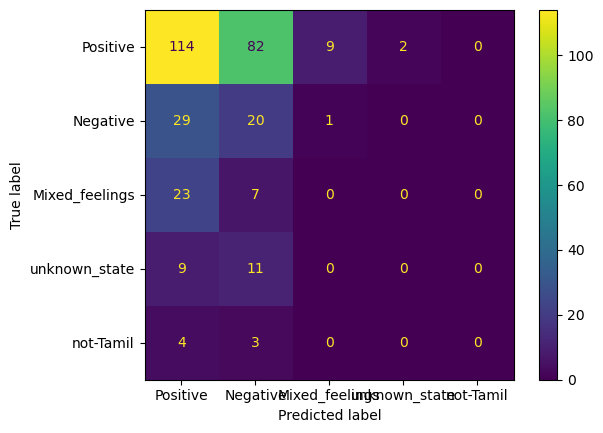

In [13]:
%matplotlib inline

# Lets explore our confusion matrix
cm = sklearn.metrics.confusion_matrix(df['label'], df['pred'])

disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=dataset['test'].features['label'].names)
disp.plot()

pd.crosstab(df['label'], df['pred'])

In [14]:
# And some overall metrics
print(sklearn.metrics.classification_report(df['label'], df['pred'], target_names=dataset['test'].features['label'].names, zero_division=1))

                precision    recall  f1-score   support

      Positive       0.64      0.55      0.59       207
      Negative       0.16      0.40      0.23        50
Mixed_feelings       0.00      0.00      0.00        30
 unknown_state       0.00      0.00      0.00        20
     not-Tamil       1.00      0.00      0.00         7

      accuracy                           0.43       314
     macro avg       0.36      0.19      0.16       314
  weighted avg       0.47      0.43      0.43       314

